# Metric results comp notebook
This notebook just calcs and compares metrics of different models preds on the test set

In [1]:
import torch
import os
import sys
import torchmetrics
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [2]:
sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from util_folder.ml_utils.result_utils.plot_utils import plotNet
from util_folder.dotdict import DotDict
from util_folder.ml_utils.result_utils.metric_utils import (generate_masks, 
                                                            MetricObj, 
                                                            calc_aggregates, 
                                                            create_res_df, 
                                                            create_test_metrics)
from util_folder.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits

In [3]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

In [4]:
inf_base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/informed_baseline_comp/'
base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/baseline_comp/'
model_names = os.listdir(base_dir)
model_names = ['dcrnn', 'inf_dcrnn']
random_seeds = [41,42,43,44]

y_true = torch.load(f'{base_dir}/{model_names[0]}/y_true_{random_seeds[0]}.pt').cpu()

In [5]:
model_paths = [base_dir + 'dcrnn/', inf_base_dir + 'inf_dcrnn']

In [6]:
results_dict = {}
for i, name in enumerate(model_names):
    results_dict[name] = {}
    for seed in random_seeds:
        results_dict[name][seed] = torch.load(f'{model_paths[i]}/y_hat_{seed}.pt').cpu()
        assert (torch.load(f'{model_paths[i]}/y_true_{seed}.pt').cpu() - y_true).sum() == 0

In [7]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)

*** DATA SUMMARY: ***
input_full.shape=torch.Size([10270, 147, 6, 10, 5])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [8]:
metric_obj = MetricObj(bce_pos_weight=25.5191)

full_test = {}
for model in model_names:
    full_test[model] = {}
    for seed in random_seeds:
        full_test[model][seed] = metric_obj.calc_metrics(y_hat=results_dict[model][seed], y_true=y_true)
full_test_aggregates = calc_aggregates(full_test, model_names, random_seeds)
full_test_df = create_res_df(full_test_aggregates)
del full_test

upstream_test_df, not_upstream_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, upstream_mask)
multilane_test_df, not_multilane_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, multilane_mask)
highway_test_df, not_highway_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, highway_mask)
spreading_test_df, not_spreading_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, spreading_mask)
affected_test_df, not_affected_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_mask)

In [9]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, n_hop_mask)
    n_hop_dfs[hop] = temp_df

In [10]:
affected_n_hop_dfs = {}
for hop in range(11):
    affected_n_hop_mask = (test_dataset.network_info[:,:,0] == -hop) & affected_mask
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_n_hop_mask)
    affected_n_hop_dfs[hop] = temp_df

In [11]:
df_arr = [full_test_df,
          upstream_test_df, not_upstream_test_df,
          multilane_test_df, not_multilane_test_df, 
          highway_test_df, not_highway_test_df, 
          spreading_test_df, not_spreading_test_df]


In [12]:

def print_res_df(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys().get_level_values(0).unique():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            mean = res_dict[loss_part][metric]["mean"]
            std = res_dict[loss_part][metric]["std"]
            metric_str +=  f'{metric} : {mean:.03f} ({std:.03f}) \t'
        print(metric_str)

In [13]:
#for model in full_test_df.keys().get_level_values(0):
    #print_res_dict(full_test_df[model], model)
pd.set_option('display.max_rows', 500)
full_test_df.T

mean            std
dcrnn     end   mae    4.168804e+00       0.220662
                mape   1.609393e+06  205406.875000
                Mmape  9.163628e-01       0.009632
          start mae    1.299280e+00       0.071599
                mape   4.806613e+05   66333.992188
                Mmape  9.016482e-01       0.009476
          speed mae    1.253791e+00       0.073244
                mape   4.111196e+05   67557.296875
                Mmape  9.334273e-01       0.008873
          class acc    8.449309e-01       0.022289
                f1     1.518253e-01       0.009080
                prcsn  1.055989e-01       0.003494
                rcll   4.155527e-01       0.065817
inf_dcrnn end   mae    2.556521e+00       0.100629
                mape   1.001877e+06   77356.625000
                Mmape  4.878888e-01       0.011920
          start mae    8.719670e-01       0.022980
                mape   3.230272e+05   24012.335938
                Mmape  4.829942e-01       0.031072
          speed mae    7.676415e-01       0.025426
                mape   3.026236e+05   18511.802734
                Mmape  5.022999e-01       0.019142
          class acc    9.471928e-01       0.005140
                f1     5.498592e-01       0.028061
                prcsn  4.147227e-01       0.023823
                rcll   9.633937e-01       0.011511

# dcrnn

In [14]:
focus_model = 'dcrnn'

In [15]:
full_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  4.168804  1609392.750  0.916363  1.299280  480661.312500  0.901648   
std   0.220662   205406.875  0.009632  0.071599   66333.992188  0.009476   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.253791  411119.562500  0.933427  0.844931  0.151825  0.105599   
std   0.073244   67557.296875  0.008873  0.022289  0.009080  0.003494   

                
          rcll  
mean  0.415553  
std   0.065817

In [16]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  17.533247  2.115488e+06  0.916363  5.593444  631599.37500  0.901648   
std    0.106358  1.854723e+05  0.009632  0.031616   54133.59375  0.009476   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.692010  513850.562500  0.933427  0.674625  0.437711  0.363537   
std   0.049629   76548.117188  0.008873  0.012127  0.012369  0.007117   

                
          rcll  
mean  0.415553  
std   0.065817

In [17]:
not_upstream_test_df[focus_model]

end                         start                      speed  \
           mae          mape Mmape       mae       mape Mmape       mae   
mean  1.777018  1.518818e+06   NaN  0.530769  453648.50   NaN  0.459499   
std   0.244562  2.090279e+05   NaN  0.080384   68704.25   NaN  0.077520   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  392734.187500   NaN  0.875410  0.0   0.0  0.0  
std    66256.148438   NaN  0.024202  0.0   0.0  0.0

In [18]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.912317  1.532008e+06  0.915669  1.529378  457474.218750  0.899555   
std   0.202601  1.951455e+05  0.009240  0.066124   63290.652344  0.008989   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.516421  392931.593750  0.932899  0.844733  0.199522  0.145595   
std   0.067801   64566.980469  0.008711  0.020240  0.011059  0.004644   

                
          rcll  
mean  0.430619  
std   0.069247

In [19]:
not_multilane_test_df[focus_model]

end                           start                           \
           mae        mape     Mmape       mae           mape     Mmape   
mean  3.207878  1709406.00  0.918428  1.001898  510628.593750  0.907876   
std   0.245524   219323.75  0.010821  0.079002   70432.132812  0.010944   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.914365  434625.937500  0.934999  0.845187  0.084223  0.054202   
std   0.080477   71498.171875  0.009374  0.024951  0.005102  0.002372   

                
          rcll  
mean  0.370717  
std   0.056342

In [20]:
highway_test_df[focus_model] 

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  4.416198  1.598509e+06  0.915977  1.401861  476845.71875  0.903560   
std   0.212462  2.013501e+05  0.010410  0.068868   64942.40625  0.010139   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.371479  409347.375000  0.933697  0.843043  0.167778  0.117345   
std   0.071167   66638.796875  0.009144  0.021659  0.008603  0.003787   

                
          rcll  
mean  0.419444  
std   0.071795

In [21]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.759676  1.627392e+06  0.917239  1.129636  486971.375000  0.897312   
std   0.234752  2.122754e+05  0.008101  0.076317   68719.726562  0.008541   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.059164  414050.406250  0.932816  0.848053  0.123751  0.085641   
std   0.076706   69082.257812  0.008321  0.023334  0.009625  0.004616   

                
          rcll  
mean  0.406726  
std   0.053170

In [22]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.831846  2.043976e+06  0.913919  1.820404  611300.125000  0.898497   
std   0.266708  2.531966e+05  0.009711  0.087150   82227.960938  0.009545   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.745012  519847.68750  0.931142  0.799450  0.176795  0.124399  0.430774  
std   0.087853   82524.84375  0.009053  0.026984  0.009481  0.003904  0.067407

In [23]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.094136  805926.312500  0.970638  0.335815  239133.531250  0.971630   
std   0.135716  117055.054688  0.007923  0.042864   36949.523438  0.008017   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.345612  210100.765625  0.984168  0.929017  0.010063  0.005185   
std   0.046292   39891.433594  0.004920  0.013643  0.000838  0.001062   

                
          rcll  
mean  0.077551  
std   0.030725

In [24]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  60.695992  0.916363  0.916363  19.567312  0.901648  0.901648  20.519917   
std    0.579751  0.009632  0.009632   0.167901  0.009476  0.009476   0.166709   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.933427  0.933427  0.415553  0.737952   1.0  0.415553  
std   0.008873  0.008873  0.065817  0.063811   0.0  0.065817

In [25]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.956678  1.672374e+06   NaN  0.584382  499471.375000   NaN  0.499834   
std   0.249731  2.134454e+05   NaN  0.080648   68929.890625   NaN  0.082135   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  427208.218750   NaN  0.861734  0.0   0.0  0.0  
std    70201.054688   NaN  0.025702  0.0   0.0  0.0

In [26]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.41	 0.30	 0.86	 0.16	 8.56	 35.61	 17.40
1:	 0.53	 0.48	 0.89	 0.22	 7.28	 31.56	 13.31
2:	 0.57	 0.59	 0.78	 0.27	 7.08	 27.85	 10.80
3:	 0.60	 0.65	 0.70	 0.34	 7.10	 25.57	 9.15
4:	 0.61	 0.67	 0.63	 0.39	 7.06	 25.01	 8.24
5:	 0.60	 0.70	 0.58	 0.46	 6.66	 23.58	 7.32
6:	 0.61	 0.72	 0.55	 0.52	 6.73	 22.70	 6.89
7:	 0.60	 0.73	 0.53	 0.57	 6.97	 22.02	 6.57
8:	 0.57	 0.73	 0.49	 0.60	 6.96	 20.38	 6.06
9:	 0.54	 0.73	 0.46	 0.63	 7.42	 20.16	 5.74
10:	 0.52	 0.74	 0.43	 0.66	 7.51	 18.74	 5.14


In [27]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.42	 0.16	 1.00	 0.16	 10.57	 44.04	 21.59
1:	 0.55	 0.22	 1.00	 0.22	 11.11	 48.27	 20.41
2:	 0.63	 0.27	 1.00	 0.27	 13.47	 53.20	 20.77
3:	 0.70	 0.34	 1.00	 0.34	 15.66	 56.58	 20.47
4:	 0.75	 0.39	 1.00	 0.39	 17.25	 61.27	 20.45
5:	 0.80	 0.46	 1.00	 0.46	 18.30	 65.11	 20.50
6:	 0.85	 0.52	 1.00	 0.52	 19.97	 67.44	 20.82
7:	 0.86	 0.57	 1.00	 0.57	 22.03	 69.12	 20.95
8:	 0.88	 0.60	 1.00	 0.60	 24.43	 70.38	 21.34
9:	 0.89	 0.63	 1.00	 0.63	 27.53	 72.77	 21.05
10:	 0.91	 0.66	 1.00	 0.66	 30.91	 73.93	 20.59


Text(0.5, 1.0, 'dcrnn')

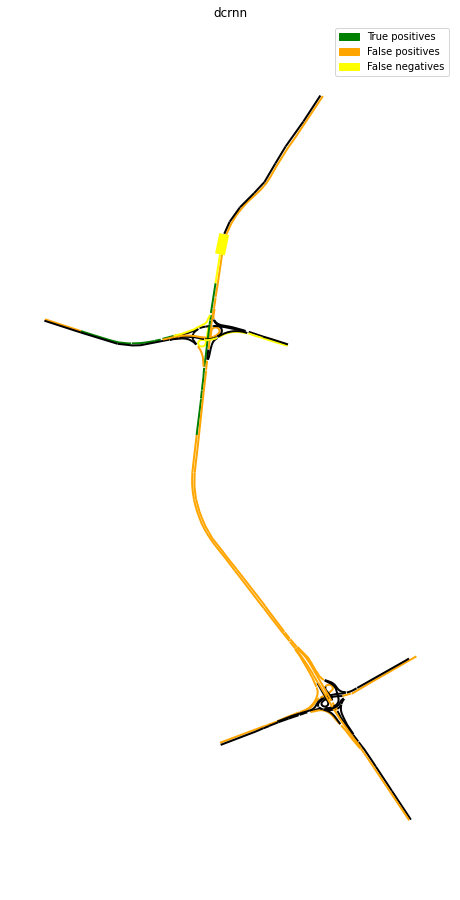

In [28]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'dcrnn')

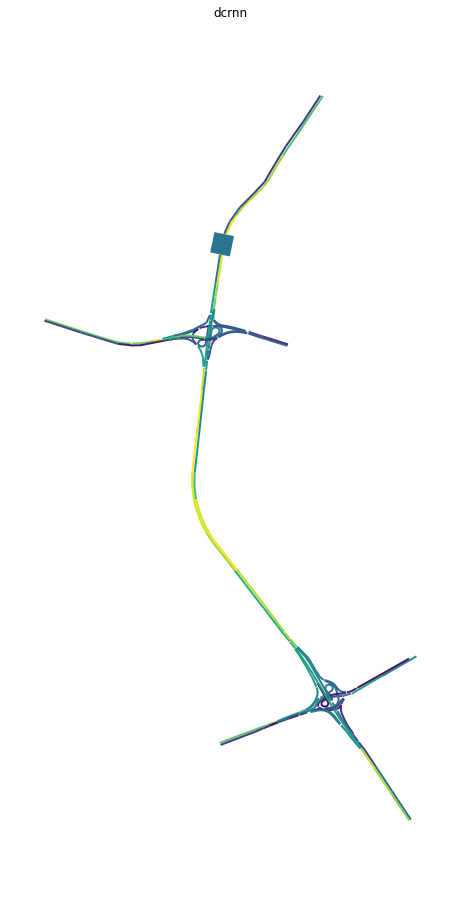

In [29]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

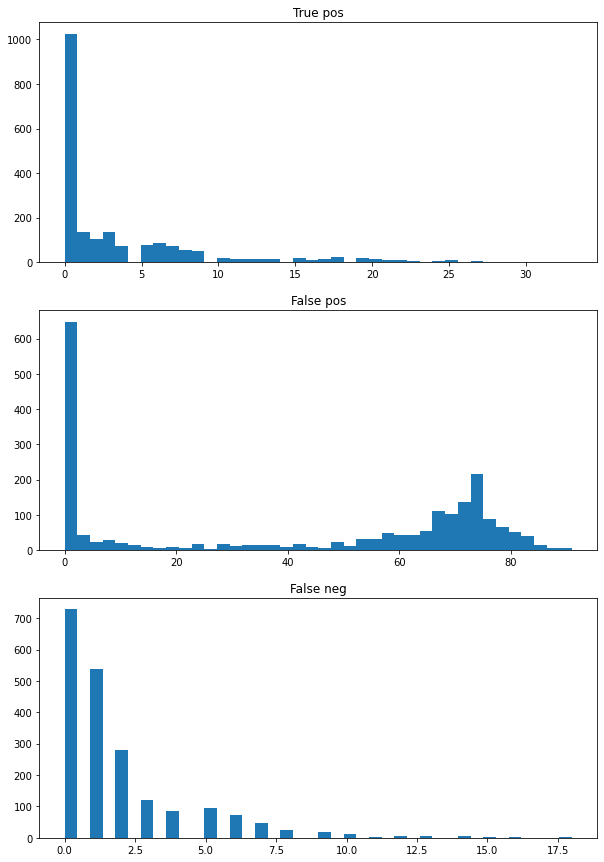

In [30]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=40)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=40)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=40)
ax[2].set_title('False neg')



# Inf_dcrnn

In [31]:
focus_model = 'inf_dcrnn'

In [32]:
full_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  2.556521  1001876.750  0.487889  0.871967  323027.218750  0.482994   
std   0.100629    77356.625  0.011920  0.022980   24012.335938  0.031072   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.767641  302623.625000  0.502300  0.947193  0.549859  0.414723   
std   0.025426   18511.802734  0.019142  0.005140  0.028061  0.023823   

                
          rcll  
mean  0.963394  
std   0.011511

In [33]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  16.841446  6.600006e+06  0.487889  5.744206  2.127988e+06  0.482994   
std    0.662907  5.095979e+05  0.011920  0.151382  1.581847e+05  0.031072   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  5.056948  1.993576e+06  0.502300  0.652125  0.549859  0.414723  0.963394  
std   0.167498  1.219492e+05  0.019142  0.033861  0.028061  0.023823  0.011511

In [34]:
not_upstream_test_df[focus_model]

end            start            speed            class                
      mae mape Mmape   mae mape Mmape   mae mape Mmape   acc   f1 prcsn rcll
mean  0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   1.0  0.0   0.0  0.0
std   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   0.0  0.0

In [35]:
multilane_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.874003  827007.312500  0.492386  0.994478  274056.718750  0.496038   
std   0.147594   90750.648438  0.016554  0.030982   28271.152344  0.029676   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.873769  250017.687500  0.514499  0.949981  0.626429  0.501313   
std   0.038215   21340.359375  0.024100  0.005860  0.031343  0.030258   

                
          rcll  
mean  0.957349  
std   0.013992

In [36]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.146204  1.227880e+06  0.474506  0.713633  386317.187500  0.444176   
std   0.085337  7.214227e+04  0.028674  0.025984   21973.527344  0.042435   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.630481  370612.125000  0.465995  0.943589  0.404478  0.276234   
std   0.019070   17511.898438  0.008015  0.004242  0.021561  0.014675   

                
          rcll  
mean  0.981381  
std   0.005290

In [37]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.091002  1.309790e+06  0.494816  1.070670  424536.500000  0.494774   
std   0.132705  1.039978e+05  0.013680  0.033039   33125.101562  0.029021   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  0.942866  394473.437500  0.508545  0.930966  0.509533  0.374968  0.95771  
std   0.029503   24052.923828  0.023416  0.006602  0.027483  0.022635  0.01363

In [38]:
not_highway_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  1.672625  492666.90625  0.472174  0.543362  155156.53125  0.456273   
std   0.051721   39343.56250  0.021060  0.008034   11193.81250  0.040109   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.477864  150727.312500  0.488133  0.974028  0.668951  0.542893   
std   0.019072   10517.794922  0.010596  0.002807  0.028989  0.027102   

                
          rcll  
mean  0.976286  
std   0.007438

In [39]:
spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.237894  977127.125000  0.490852  1.123605  324989.937500  0.482405   
std   0.083290   83493.570312  0.013064  0.024873   26978.640625  0.027754   

         speed                              class                               
           mae           mape     Mmape       acc       f1     prcsn      rcll  
mean  0.935557  274607.500000  0.505701  0.950639  0.65810  0.531746  0.962435  
std   0.023965   19153.007812  0.021032  0.005259  0.02853  0.027481  0.011494

In [40]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  1.296784  1.047634e+06  0.422096  0.406733  319398.468750  0.496076   
std   0.154718  1.360721e+05  0.055295  0.041511   40115.496094  0.133018   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.457196  354420.437500  0.426768  0.940821  0.119713  0.071827   
std   0.029466   28062.972656  0.027689  0.004934  0.009550  0.005507   

                
          rcll  
mean  0.984694  
std   0.012074

In [41]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  36.758457  0.487889  0.487889  13.118016  0.482994  0.482994  10.981713   
std    1.124443  0.011920  0.011920   0.263333  0.031072  0.031072   0.458330   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.502300  0.502300  0.963394  0.988603   1.0  0.963394  
std   0.019142  0.019142  0.011511  0.004034   0.0  0.011511

In [42]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.218068  1.041084e+06   NaN  0.392732  335668.500000   NaN  0.367926   
std   0.094049  8.038380e+04   NaN  0.029194   24952.011719   NaN  0.022506   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  314466.437500   NaN  0.946559  0.0   0.0  0.0  
std    19236.248047   NaN  0.005425  0.0   0.0  0.0

In [43]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.89	 0.81	 0.81	 1.00	 5.43	 20.84	 8.27
1:	 0.79	 0.67	 0.67	 0.99	 5.47	 22.10	 8.28
2:	 0.70	 0.58	 0.55	 0.99	 6.17	 22.59	 8.33
3:	 0.64	 0.54	 0.49	 0.99	 6.71	 23.16	 8.03
4:	 0.60	 0.52	 0.45	 0.99	 7.00	 24.12	 7.86
5:	 0.55	 0.49	 0.40	 0.99	 7.23	 24.99	 7.69
6:	 0.53	 0.48	 0.37	 0.99	 7.60	 25.15	 7.66
7:	 0.51	 0.48	 0.36	 0.99	 8.03	 24.94	 7.52
8:	 0.47	 0.47	 0.33	 0.98	 8.37	 24.27	 7.25
9:	 0.46	 0.49	 0.32	 0.96	 8.84	 24.08	 6.87
10:	 0.43	 0.50	 0.30	 0.96	 9.17	 23.38	 6.38


In [44]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 1.00	 1.00	 1.00	 1.00	 5.19	 19.52	 7.23
1:	 1.00	 0.99	 1.00	 0.99	 5.66	 23.86	 8.09
2:	 1.00	 0.99	 1.00	 0.99	 7.13	 26.92	 9.48
3:	 1.00	 0.99	 1.00	 0.99	 8.46	 29.55	 10.00
4:	 1.00	 0.99	 1.00	 0.99	 9.47	 33.54	 10.59
5:	 1.00	 0.99	 1.00	 0.99	 10.22	 37.10	 11.07
6:	 1.00	 0.99	 1.00	 0.99	 11.79	 39.84	 12.04
7:	 1.00	 0.99	 1.00	 0.99	 14.04	 42.42	 12.96
8:	 1.00	 0.98	 1.00	 0.98	 16.72	 44.77	 14.07
9:	 0.99	 0.96	 1.00	 0.96	 20.16	 49.03	 14.49
10:	 0.99	 0.96	 1.00	 0.96	 24.25	 53.17	 14.91


Text(0.5, 1.0, 'inf_dcrnn')

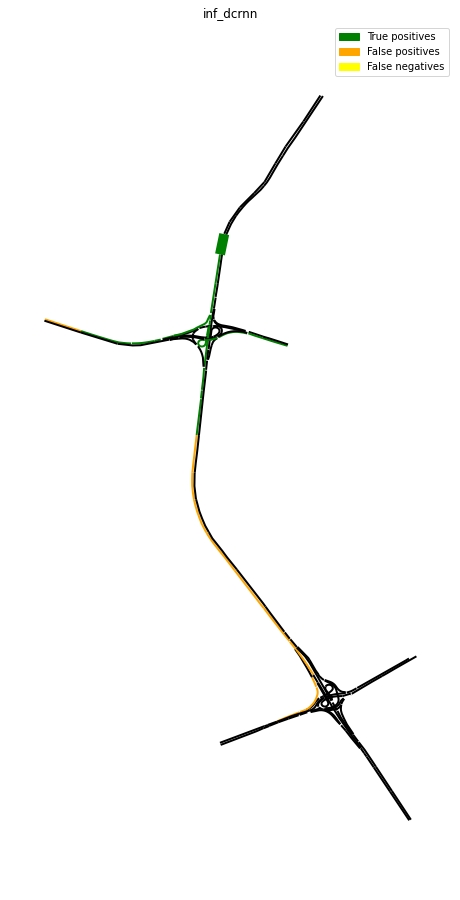

In [45]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_dcrnn')

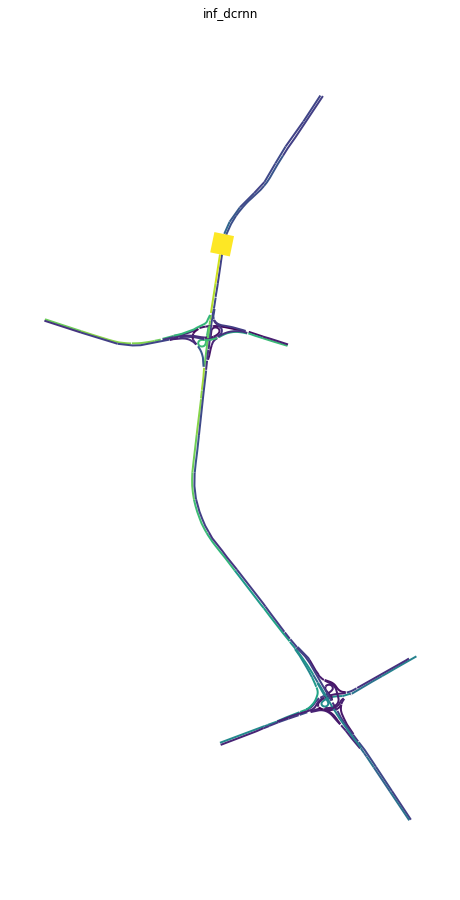

In [46]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

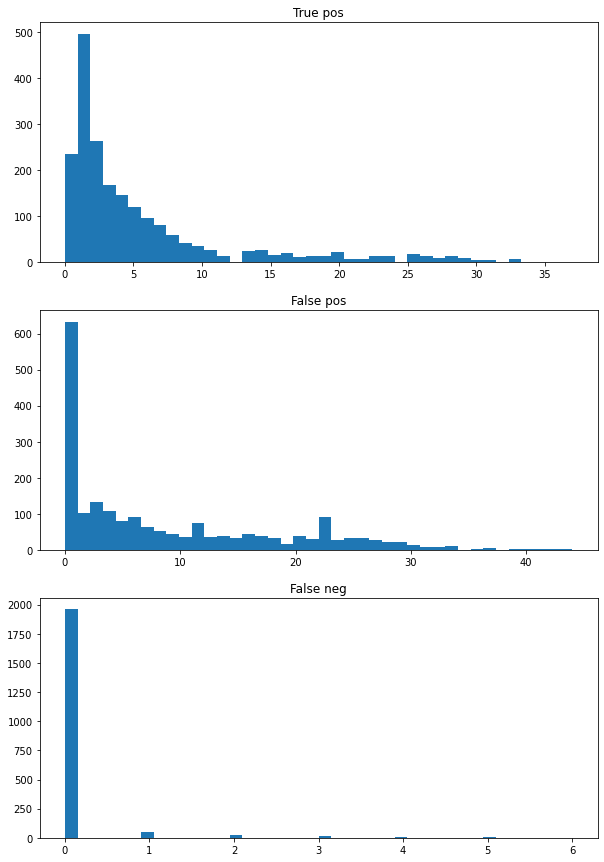

In [47]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=40)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=40)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=40)
ax[2].set_title('False neg')



# Comparison

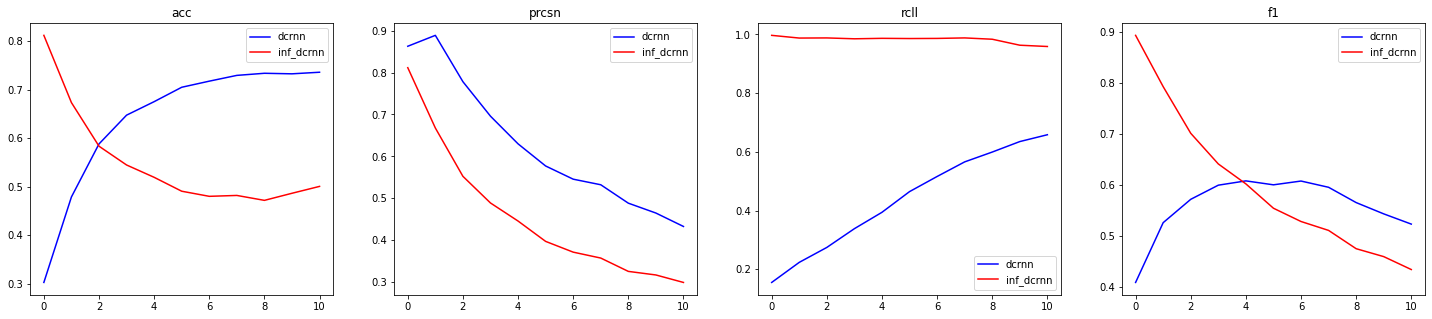

In [48]:
def class_comp_plot(metric, ax):
    dcrnn_mean = [n_hop_dfs[hop]['dcrnn']['class'][metric]['mean'] for hop in n_hop_dfs.keys()]
    dcrnn_std = [n_hop_dfs[hop]['dcrnn']['class'][metric]['std'] for hop in n_hop_dfs.keys()]

    inf_dcrnn_mean = [n_hop_dfs[hop]['inf_dcrnn']['class'][metric]['mean'] for hop in n_hop_dfs.keys()]
    inf_dcrnn_std = [n_hop_dfs[hop]['inf_dcrnn']['class'][metric]['std'] for hop in n_hop_dfs.keys()]

    ax.plot(dcrnn_mean, color='blue', label='dcrnn')
    ax.plot(inf_dcrnn_mean, color='red', label='inf_dcrnn')
    ax.set_title(metric)
    ax.legend()
    return ax

metrics = ['acc', 'prcsn', 'rcll', 'f1']

fig, axs = plt.subplots(1,4, figsize=(25,5))
for i, metric in enumerate(metrics):
    axs[i] = class_comp_plot(metric, axs[i])

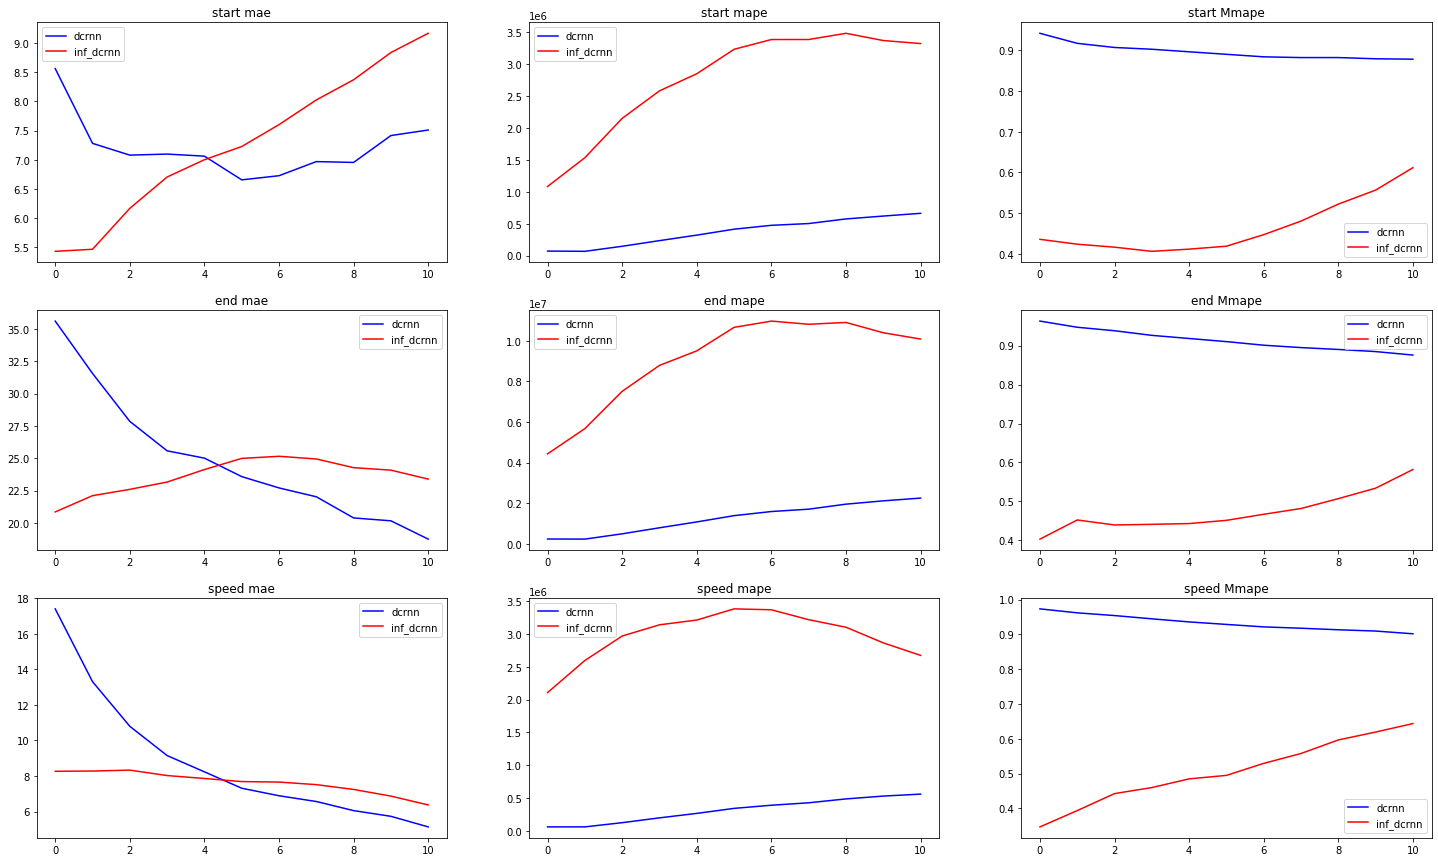

In [49]:
def class_comp_plot(loss_part, metric, ax):
    dcrnn_mean = [n_hop_dfs[hop]['dcrnn'][loss_part][metric]['mean'] for hop in n_hop_dfs.keys()]
    dcrnn_std = [n_hop_dfs[hop]['dcrnn'][loss_part][metric]['std'] for hop in n_hop_dfs.keys()]

    inf_dcrnn_mean = [n_hop_dfs[hop]['inf_dcrnn'][loss_part][metric]['mean'] for hop in n_hop_dfs.keys()]
    inf_dcrnn_std = [n_hop_dfs[hop]['inf_dcrnn'][loss_part][metric]['std'] for hop in n_hop_dfs.keys()]

    ax.plot(dcrnn_mean, color='blue', label='dcrnn')
    ax.plot(inf_dcrnn_mean, color='red', label='inf_dcrnn')
    ax.set_title(f'{loss_part} {metric}')
    ax.legend()
    return ax

loss_parts = ['start', 'end', 'speed']
metrics = ['mae', 'mape', 'Mmape']

fig, axs = plt.subplots(3,3, figsize=(25,15))
for i, loss_part in enumerate(loss_parts):
    for j, metric in enumerate(metrics):
        axs[i,j] = class_comp_plot(loss_part, metric, axs[i,j])

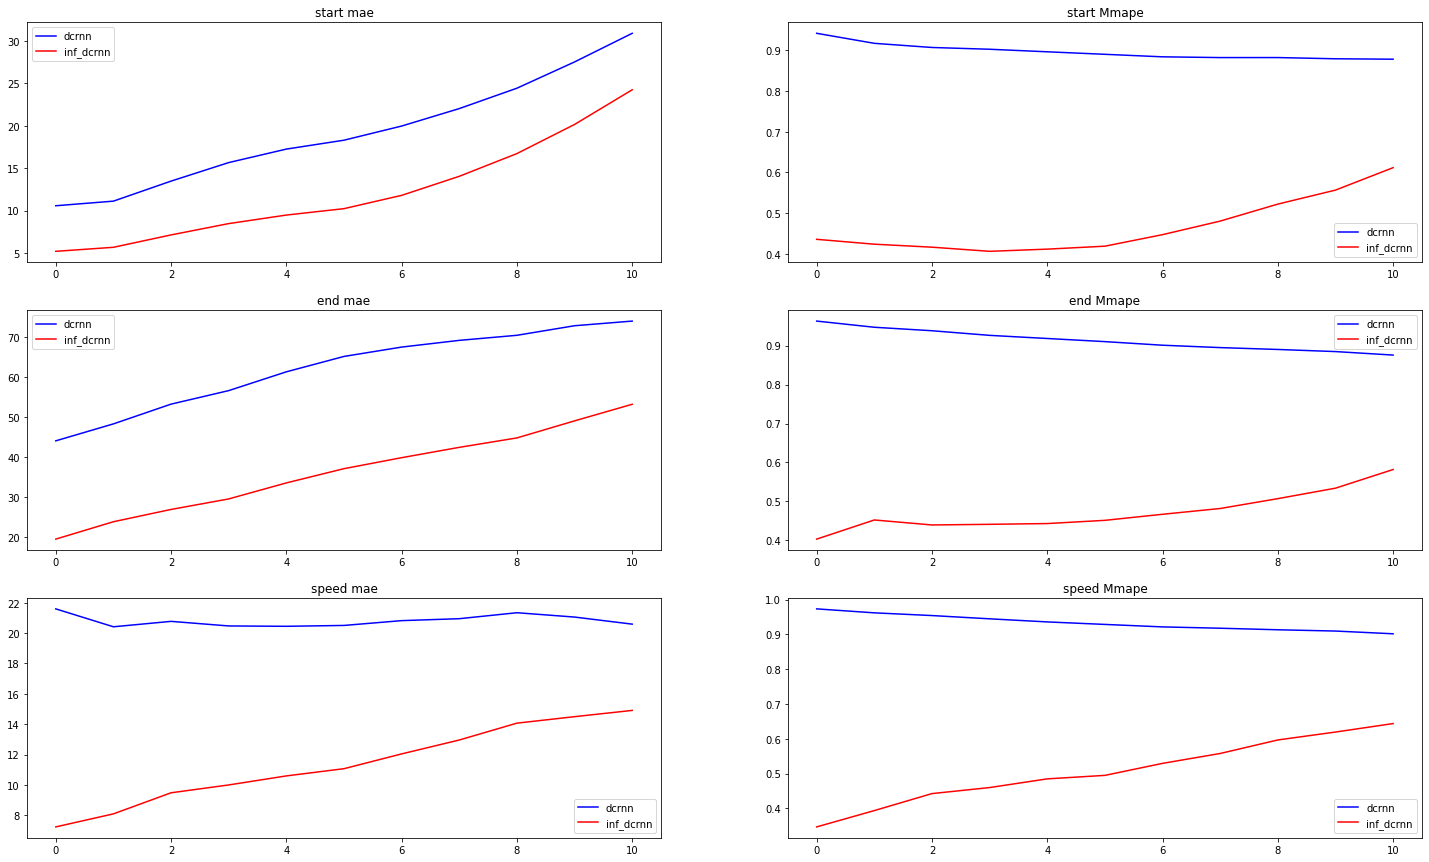

In [50]:
def class_comp_plot(loss_part, metric, ax):
    dcrnn_mean = [affected_n_hop_dfs[hop]['dcrnn'][loss_part][metric]['mean'] for hop in n_hop_dfs.keys()]
    dcrnn_std = [affected_n_hop_dfs[hop]['dcrnn'][loss_part][metric]['std'] for hop in n_hop_dfs.keys()]

    inf_dcrnn_mean = [affected_n_hop_dfs[hop]['inf_dcrnn'][loss_part][metric]['mean'] for hop in n_hop_dfs.keys()]
    inf_dcrnn_std = [affected_n_hop_dfs[hop]['inf_dcrnn'][loss_part][metric]['std'] for hop in n_hop_dfs.keys()]

    ax.plot(dcrnn_mean, color='blue', label='dcrnn')
    ax.plot(inf_dcrnn_mean, color='red', label='inf_dcrnn')
    ax.set_title(f'{loss_part} {metric}')
    ax.legend()
    return ax

loss_parts = ['start', 'end', 'speed']
metrics = ['mae', 'Mmape']

fig, axs = plt.subplots(3,2, figsize=(25,15))
for i, loss_part in enumerate(loss_parts):
    for j, metric in enumerate(metrics):
        axs[i,j] = class_comp_plot(loss_part, metric, axs[i,j])